In [2]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.ticker as ticker
import yt

# Define Alpha

In [145]:
def alpha(t, M, c_s, V, R, z, min=np.log(4e-1)):
    """
    Analytic solution of Plummer potential, for varying R and z.
    
    Parameters:
    - t: fixed time
    - M: mass of perturber
    - c_s: speed of sound
    - V: velocity of perturber
    - R: radial distance in the x-y plane
    - z: distance in z-axis
    
    Returns:
    - alpha at time t
    """
    # Constants
    G = 6.67430e-8  # Gravitational constant in cm**3/(g*s**2)
    
    # Avoid division by zero for t=0 by setting alpha to 0 in this case
    if t == 0:
        return 0
    
    # Flip the z-direction
    z = -1.0*z

    s = z - V * t
    Mach = V / c_s
    mach_term = 1 - Mach**2
    
    # Take absolute value of R
    R = np.abs(R)
    
    # Check for negative square root condition
    alpha_val = G * M / (c_s**2) / np.sqrt(s**2 + R**2 * mach_term)
    
    # Condition-based factor
    if (R**2 + z**2) < (c_s * t)**2:
        #print('R**2 + z**2 < c_s * t')
        result = alpha_val
    elif (Mach > 1) and ((R**2 + z**2) > (c_s * t)**2) and (s/np.abs(R) < (-1.0 * np.sqrt(Mach**2 -1))) and (z > (c_s * t) / Mach):
        #print('Mach > 1')
        result = alpha_val * 2
    else:
        return min  # or some default value

    # Normalization constant
    norm_factor = np.log(G*M/(t*c_s**3))

    # Compute the normalized log of alpha
    log_alpha = np.log(result) - norm_factor

    return log_alpha

# Reproduce Ostriker plot

/tmp/ipykernel_2867490/873572243.py:34: RuntimeWarning: invalid value encountered in sqrt
  alpha_val = G * M / (c_s**2) / np.sqrt(s**2 + R**2 * mach_term)


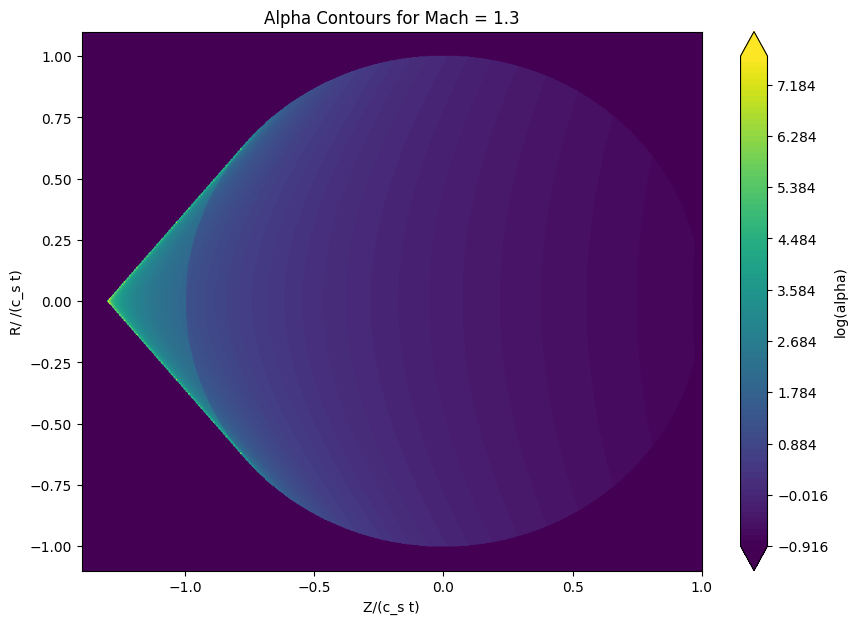

In [146]:
# Fixed parameters
t = 1 # Fixed time in seconds
M = 1.3536264996732447e-30  # Mass of perturber in grams
c_s = 1.0  # Speed of sound in cm/s
V = 1.3 # Velocity of perturber in cm/s

# Generate a grid of R and z values
#R = np.linspace(0, 1000000, 100)  # Radial distance in cm
R = np.linspace(-1.1, 1.1, 800)  # Distance in z-axis in cm
z = np.linspace(-1.4, 1.0, 800)  # Distance in z-axis in cm
Z, R = np.meshgrid(z, R)

# Calculate alpha values for each combination of R and z
log_alpha = np.vectorize(alpha)(t, M, c_s, V, R, Z)

# Plot contours
plt.figure(figsize=(10, 7))

# Generate contour levels in intervals of 0.1
min_log_alpha = np.nanmin(log_alpha)
max_log_alpha = np.nanmax(log_alpha)
levels = np.arange(min_log_alpha, max_log_alpha, 0.1)

contour = plt.contourf(Z/(c_s*t), R/(c_s*t), log_alpha, levels=levels, cmap='viridis', extend='both')
plt.colorbar(contour, label='log(alpha)')
plt.title('Alpha Contours for Mach = %s' % V)
plt.xlabel('Z/(c_s t)')
plt.ylabel('R/ /(c_s t)')
plt.show()

### 

In [174]:
# Specify the dataset dump or get the last one from the OutputLog
dataset_dump = "DD0430"

# Load the dataset
ds = yt.load(f"/home/sgordon/software/enzo-dev/run/Hydro/Hydro-3D/BenProblem3D/Dim256_Mach1.3/{dataset_dump}/noh3D_{dataset_dump[-4:]}")

# Create a projection plot of the density field along the z-axis
axis = 'z'
p = yt.ProjectionPlot(ds, axis, 'density', weight_field=None)

yt : [INFO     ] 2024-03-25 11:43:01,156 Parameters: current_time              = 2000
yt : [INFO     ] 2024-03-25 11:43:01,158 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-03-25 11:43:01,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-25 11:43:01,160 Parameters: domain_right_edge         = [10. 10. 10.]
yt : [INFO     ] 2024-03-25 11:43:01,162 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-25 11:43:01,167 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-03-25 11:43:31,183 Projection completed
yt : [INFO     ] 2024-03-25 11:43:31,185 xlim = 0.000000 10.000000
yt : [INFO     ] 2024-03-25 11:43:31,186 ylim = 0.000000 10.000000
yt : [INFO     ] 2024-03-25 11:43:31,189 xlim = 0.000000 10.000000
yt : [INFO     ] 2024-03-25 11:43:31,189 ylim = 0.000000 10.000000
yt : [INFO     ] 2024-03-25 11:43:31,191 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


In [148]:
ds.current_time.in_units('Myr')

unyt_quantity(1999.96197429, 'Myr')

# Plot 1: Analytic solution contours overlaid on numerical density map

In [149]:
# Create a Fixed Resolution Buffer (FRB)
width = 10.0  # Define the width of the FRB, this might need to be adjusted
res = [800, 800]  # The resolution of the FRB, adjust as needed

# Create FRB (this part might require adjustment based on your specific data and needs)
frb = p.data_source.to_frb(width, res)

# Extract density data from FRB
density_data = frb[('gas', 'density')].d # g/cm^2

# Create a grid for the alpha function (this might require adjusting the limits to match your data)
x = np.linspace(-width/2, width/2, res[0]) # kpc
y = np.linspace(-width/2, width/2, res[1])
X, Y = np.meshgrid(x, y)

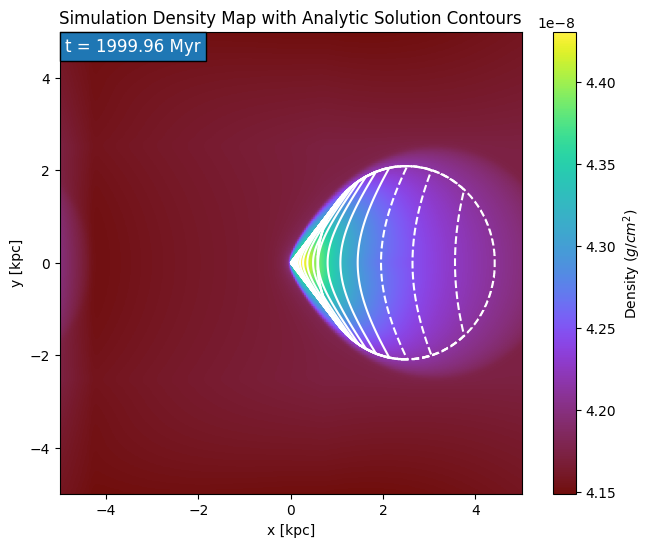

In [150]:
# Plot the density map from the frb and the alpha contours
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(np.array(density_data), extent=(-width/2, width/2, -width/2, width/2), origin='lower', cmap='arbre')

# Adding the text to the top left corner, with a small margin from the axes
margin = 0.12
ax.text(x=-width/2 + margin, y=width/2 - margin, s="t = {:.2f}".format(ds.current_time.in_units('Myr')),
        verticalalignment='top', horizontalalignment='left',
        color='white', fontsize=12, backgroundcolor=None)

# Add a colorbar for the density
cbar = fig.colorbar(img)
cbar.set_label('Density $(g/cm^2)$')

# Define the ranges for x and y, choose limits that make sense for your situation
x_limits = (-5, 5)  # Example limits for x
y_limits = (-5, 5)  # Example limits for y

# Plot the contours of the alpha function, scaled to (-5, 5) for x and y
contour_levels = np.arange(min_log_alpha, max_log_alpha, 0.3)  # 0.1 spaced levels
factor = 5/2.3
CS = ax.contour((X+4.6)/factor, Y/factor, log_alpha, levels=contour_levels, colors='white')

# Set plot labels
ax.set_xlabel('x [kpc]')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_ylabel('y [kpc]')
ax.set_title('Simulation Density Map with Analytic Solution Contours')

plt.show()


# Plot 2

In [167]:
# Create a Fixed Resolution Buffer (FRB)
width = 10  # Define the width of the FRB, this might need to be adjusted
res = [800, 800]  # The resolution of the FRB, adjust as needed

# Create FRB (this part might require adjustment based on your specific data and needs)
frb = p.data_source.to_frb(width, res)

# Extract density data from FRB
density_data = frb[('gas', 'density')].d # g/cm^2

In [173]:
r_data = frb[('index', 'radius')]

density_data[400:]

array([[4.19632504e-08, 4.19632504e-08, 4.19632504e-08, ...,
        4.19794010e-08, 4.19794010e-08, 4.19794010e-08],
       [4.19632504e-08, 4.19632504e-08, 4.19632504e-08, ...,
        4.19794010e-08, 4.19794010e-08, 4.19794010e-08],
       [4.19632504e-08, 4.19632504e-08, 4.19632504e-08, ...,
        4.19794010e-08, 4.19794010e-08, 4.19794010e-08],
       ...,
       [4.15734287e-08, 4.15734287e-08, 4.15734287e-08, ...,
        4.15754887e-08, 4.15754887e-08, 4.15754887e-08],
       [4.15734287e-08, 4.15734287e-08, 4.15734287e-08, ...,
        4.15754887e-08, 4.15754887e-08, 4.15754887e-08],
       [4.15734287e-08, 4.15734287e-08, 4.15734287e-08, ...,
        4.15754887e-08, 4.15754887e-08, 4.15754887e-08]])

In [172]:
r_data[400:]

2.3813017928951886e+44

In [152]:
# density contours on sim projection
# p.annotate_contour('density', levels=5, take_log=True)
# p.annotate_timestamp(corner='upper_left', redshift=False)
#p.show()
#p.save('density_map_face-on.png')

In [153]:
def dynamical_timescale_ff(rho):
    # rho in g/cm^3
    return np.sqrt(3*np.pi/(32*6.67e-8*rho))/3.1557e+13
dynamical_timescale_ff(1.9891e33*20/(3.086e21**3))

# Analytic Solution at R=0

In [186]:
density_data[0,:].shape

(800,)

/tmp/ipykernel_2867490/873572243.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  elif (Mach > 1) and ((R**2 + z**2) > (c_s * t)**2) and (s/np.abs(R) < (-1.0 * np.sqrt(Mach**2 -1))) and (z > (c_s * t) / Mach):


Text(0, 0.5, '$\\alpha$')

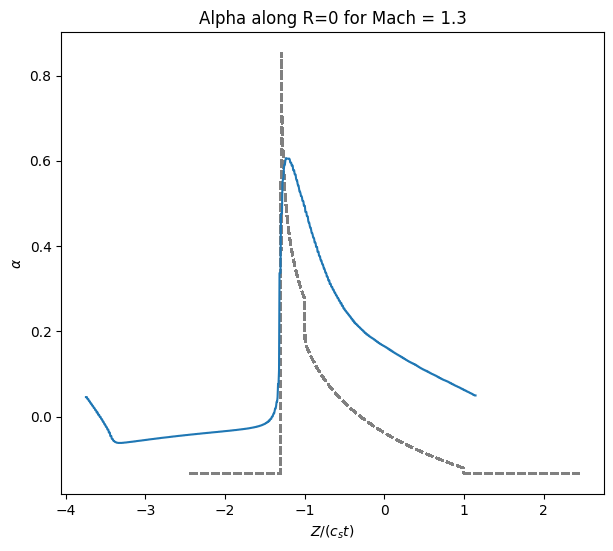

In [207]:
# Fixed parameters
t = 2000*3.1557e+13 # 2Gyr time in seconds
M = 20*1.9891e33  # Mass of perturber in grams (20 Msun)
c_s = 1e5 # Speed of sound in cm/s
V = 1.3e5# Velocity of perturber in cm/s
Mach = V/c_s

# Generate a grid of R and z values
z = np.linspace(-5*3.086e21, 5*3.086e21, 800)  # Distance in z-axis in cm
R_zero = np.zeros_like(z)
R, Z = np.meshgrid(R_zero, z)

# Calculate alpha values for R=0 and each z
density_bkg_analytic = M/3.086e21**3 #'g/cm**3' <- 20 msun/kpc^3
alpha_analytic = (-np.vectorize(alpha)(t, M, c_s, V, R, Z)/np.log(density_bkg_analytic))*10

# Simulation alpha
z2 = np.linspace(-5*3.086e21, 5*3.086e21, 800)
density_bkg = M/(3.086e21**2) #'g/cm**2' <- 20 msun/kpc^2
density_contrast_sim = np.array(density_data/density_bkg) - 10
sim_alpha = density_contrast_sim[400,:]

# Plot log_alpha along R=0
plt.figure(figsize=(7, 6))
plt.plot(z/(c_s*t), alpha_analytic, label='Analytic', linestyle='--', color='grey')
plt.plot(z2/(c_s*t)-1.3, sim_alpha, label='Simulation')
plt.title('Alpha along R=0 for Mach = %s' %Mach)
plt.xlabel(r'$Z/(c_s t)$')
plt.ylabel(r'$\alpha$')

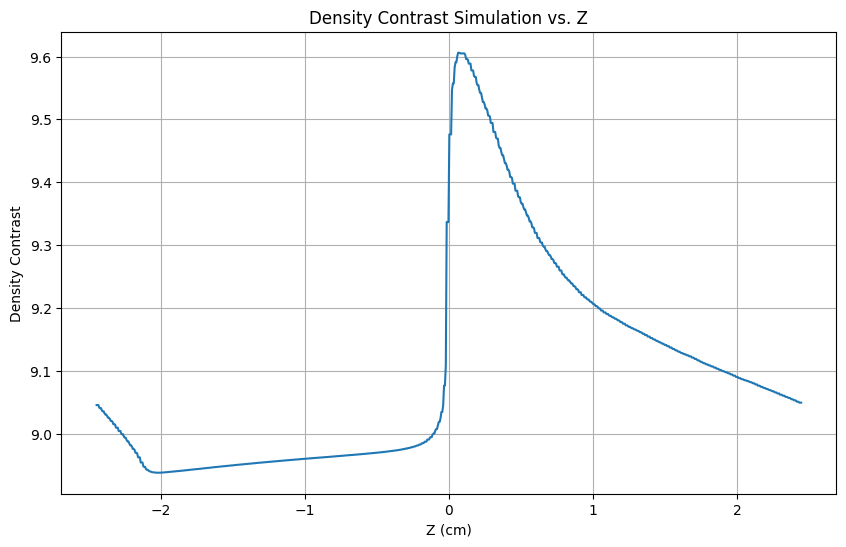

In [198]:
# Re-calculating density_contrast_sim based on the provided information
density_bkg = M/(3.086e21**2)  # 'g/cm**2' <- 20 msun/kpc^2
density_contrast_sim = np.array(density_data/density_bkg) - 1
sim_alpha = density_contrast_sim[400, :]

# z is already defined as requested
# Plotting density_contrast_sim vs z
plt.figure(figsize=(10, 6))
plt.plot(z/(c_s*t), sim_alpha, label='Density Contrast Simulation')
plt.title('Density Contrast Simulation vs. Z')
plt.xlabel('Z (cm)')
plt.ylabel('Density Contrast')
plt.grid(True)
#plt.legend()
plt.show()

In [199]:
M

3.9782000000000002e+34

In [155]:
# Find z values where sim_z is between -2 and 1
# Since sim_z is linear in z, we can directly find the z values for sim_z = -2 and sim_z = 1
sim_z_min = -2
sim_z_max = 1

# Solve for z
z_min = (sim_z_min + 1.3) * c_s * t
z_max = (sim_z_max + 1.3) * c_s * t

def sim_z(z,c_s,t):
    return z/(c_s*t) - 1.3

z = np.linspace(z_min,z_max, 800)  # Distance in z-axis in cm

sim_z(z,c_s,t)

array([-2.00000000e+00, -1.99624531e+00, -1.99249061e+00, -1.98873592e+00,
       -1.98498123e+00, -1.98122653e+00, -1.97747184e+00, -1.97371715e+00,
       -1.96996245e+00, -1.96620776e+00, -1.96245307e+00, -1.95869837e+00,
       -1.95494368e+00, -1.95118899e+00, -1.94743429e+00, -1.94367960e+00,
       -1.93992491e+00, -1.93617021e+00, -1.93241552e+00, -1.92866083e+00,
       -1.92490613e+00, -1.92115144e+00, -1.91739675e+00, -1.91364205e+00,
       -1.90988736e+00, -1.90613267e+00, -1.90237797e+00, -1.89862328e+00,
       -1.89486859e+00, -1.89111389e+00, -1.88735920e+00, -1.88360451e+00,
       -1.87984981e+00, -1.87609512e+00, -1.87234043e+00, -1.86858573e+00,
       -1.86483104e+00, -1.86107635e+00, -1.85732165e+00, -1.85356696e+00,
       -1.84981227e+00, -1.84605757e+00, -1.84230288e+00, -1.83854819e+00,
       -1.83479349e+00, -1.83103880e+00, -1.82728411e+00, -1.82352941e+00,
       -1.81977472e+00, -1.81602003e+00, -1.81226533e+00, -1.80851064e+00,
       -1.80475594e+00, -

/tmp/ipykernel_2867490/2509197050.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([f"{tick/eps:.1f}" for tick in ax[0].get_xticks()])
/tmp/ipykernel_2867490/2509197050.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([f"{tick/eps:.1f}" for tick in ax[0].get_yticks()])


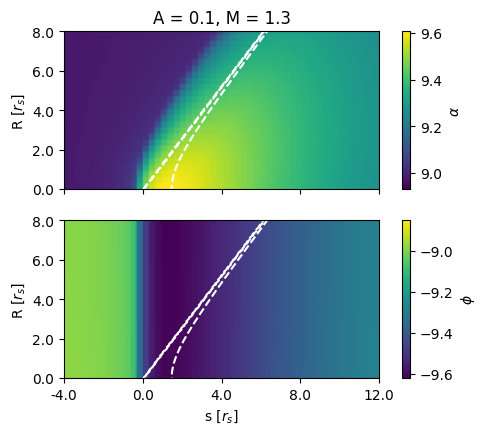

In [138]:
# Create the plot
fig, ax = plt.subplots(2, figsize=(6, 4.5), sharex=True) 

# panel 1
img = ax[0].imshow(density_contrast_sim, extent=(-width/2, width/2, -width/2, width/2), origin='lower', cmap='viridis')
ax[0].set_xlim(-0.5, 1.5)
ax[0].set_ylim(0, 1.0)
ax[0].set_ylabel(r'R [$r_s$]')
ax[0].set_title(r'A = 0.1, M = 1.3')

# Add a colorbar for the density
cbar1 = fig.colorbar(img, ax=ax[0]) 
cbar1.set_label(r'$\alpha$')

# panel 2
img = ax[1].imshow(alpha_analytic-sim_alpha, extent=(-width/2, width/2, -width/2, width/2), origin='lower', cmap='viridis', 
                   #vmin=10, vmax=10**1.1
                   )
ax[1].set_xlim(-0.5, 1.5)
ax[1].set_ylim(0, 1.0)
ax[1].set_xlabel(r's [$r_s$]')
ax[1].set_ylabel(r'R [$r_s$]')
cbar2 = fig.colorbar(img, ax=ax[1])
cbar2.set_label(r'$\phi$') 

# Adjust the tick labels to reflect the scaling
eps = 0.125
for i in range(2):
    # Set the number of ticks on the x and y axis
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(4))  # Set the maximum number of x-ticks
    ax[i].yaxis.set_major_locator(ticker.MaxNLocator(4))  # Set the maximum number of y-ticks
    ax[i].set_xticklabels([f"{tick/eps:.1f}" for tick in ax[0].get_xticks()])
    ax[i].set_yticklabels([f"{tick/eps:.1f}" for tick in ax[0].get_yticks()])

# Now plot the log(alpha) contours on top of the density map
min_log_alpha = np.nanmin(log_alpha)
max_log_alpha = np.nanmax(log_alpha)
contour_levels = np.arange(min_log_alpha, max_log_alpha, 4)  # 0.1 spaced levels
factor = 5/2.3
for i in range(2):
    CS = ax[i].contour((4.6+X)/factor, Y/factor, log_alpha, levels=contour_levels, colors='white', linestyles='dashed')